In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드 및 병합
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [2]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.7 MB/s eta 0:00:00


In [3]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import koreanize_matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [4]:
config = {
    # RNN 설정
    "RNN_hidden_layers": 3,  # LSTM Layer 개수
    "RNN_hidden_nodes": 512,  # RNN Hidden State 크기
    "RNN_FC_dim": 256,  # RNN 최종 FC Layer 뉴런 개수
    "dropout_p": 0.2,  # 드롭아웃 비율

    # 학습 설정
    "k": 4,  # 클래스 개수 (normal, yawn, phonecall, text)
    "feature_num": 5, # gaze_pitch, gaze_yaw, EAR, MAR, phone_detected
    "timestep": 12,
    "epochs": 100,  # 총 학습 횟수
    "batch_size": 32,  # 배치 크기
    "learning_rate": 5e-5,  # 학습률
    "log_interval": 5,  # 몇 번의 배치마다 로그 출력할지

    "action_names": ["normal", "phonecall", "text", "yawn"],  # 분류할 행동 리스트

    "use_cuda": torch.cuda.is_available(),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # GPU 사용 가능 여부에 따라 설정
    "early_stopping_patience": 5,  # Early Stopping 기준 Epoch
    "reduce_lr_factor": 0.5,  # Learning Rate 감소 비율
    "reduce_lr_patience": 3,  # Learning Rate 감소 기준 Epoch

    # 모델 결과 저장 경로
    "model_save_path": "/content/drive/MyDrive/DMS/LSTM_baseline/save_model",
    "train_result_path": "/content/drive/MyDrive/DMS/LSTM_baseline/train_result",
}

## 데이터 로드

In [ ]:
# 하이퍼파라미터
BATCH_SIZE = config['batch_size']
TIMESTEP = config['timestep']
FEATURE_DIM = config['feature_num'] # Pitch, Yaw, EAR, MAR (Phone_YN)
NUM_CLASSES = config['k']  # normal, phonecall, text, yawn

# CSV에서 추출된 feature 불러오기
def load_features(df):
    # 데이터 정렬
    df = df.sort_values(by=["label", "video_name", "frame"]) # 내림차순 정렬

    # 특징값만 추출
    features = df[["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]].values  # (104652, 5)

    # label 인코딩
    label_mapping = {"normal": 0, "phonecall": 1, "text": 2, "yawn": 3}
    labels = df["label"].map(label_mapping).values

    # LSTM Input 형식 변환
    num_samples = len(features) // TIMESTEP  # 전체 샘플 개수 = 8721
    # 데이터가 12프레임에 맞아 떨어지지 않는 경우 처리
    features = features[: num_samples * TIMESTEP]  # TIMESTEP에 맞게 자르기
    features = features.reshape(num_samples, TIMESTEP, FEATURE_DIM)  # (전체 샘플 개수, TIMESTEP, 4)

    labels = labels[:num_samples * TIMESTEP:TIMESTEP]  # 한 시퀀스 당 하나의 레이블 선택

    # pytorch tensor 변환
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

### create_sequences

In [ ]:
# 하이퍼파라미터
BATCH_SIZE = config['batch_size']
TIMESTEP = config['timestep']
FEATURE_DIM = config['feature_num']
NUM_CLASSES = config['k']  # normal, phonecall, text, yawn

def create_sequences(df):
    """
    video_clip을 기준으로 TIMESTEP 프레임 단위로 묶어 시퀀스를 생성하는 함수
    """
    # 데이터 정렬
    df = df.sort_values(by=["label", "video_name", "frame"]) # 내림차순 정렬

    # label 인코딩
    label_mapping = {"normal": 0, "phonecall": 1, "text": 2, "yawn": 3}
    df["label"] = df["label"].map(label_mapping).values

    # 비디오 클립별 그룹화 -> timestep 만큼 feature추출
    features = ["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]
    grouped = df.groupby(["label", "video_clip"])

    skip_cnt = [0] * config['k']
    X, y = [], []

    for _, group in grouped:
        group = group.sort_values(by="frame")  # 프레임 순서 정렬
        feature_values = group[features].values
        labels = group["label"].values

        num_samples = len(feature_values) // TIMESTEP  # 가능한 샘플 개수
        if num_samples == 0:
            # print(f"⚠ Warning: Skipping video_clip (not enough frames: {len(feature_values)})")
            skip_cnt[labels[0]] += 1
            continue # 샘플이 없으면 건너뛰기
        elif len(feature_values) % TIMESTEP != 0: # 24 로 나누어 떨어지지 않음
            skip_cnt[labels[0]] += 1

        feature_values = feature_values[:num_samples * TIMESTEP]  # timestep 단위로 자르기
        labels = labels[:num_samples * TIMESTEP]  # 라벨도 동일하게 자르기
        feature_values = feature_values.reshape(num_samples, TIMESTEP, -1) # (전체 샘플 개수, TIMESTEP, FEATURES_DIM)

        for i in range(num_samples):
            X.append(feature_values[i])
            y.append(labels[i*TIMESTEP])

    print(f"Number of video clips skipped: {skip_cnt}")

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/train_processed.csv")
test = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/test_processed.csv")

In [ ]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // config['timestep']
print("-----------Train-----------")
display(train_count)
print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // config['timestep']
display(test_count)

-----------Train-----------


,label,frame_count,clip_count
0,normal,65196,5433
1,phonecall,25296,2108
2,text,10044,837
3,yawn,4404,367


-----------Test-----------


,label,frame_count,clip_count
0,normal,14100,1175
1,phonecall,5688,474
2,text,2568,214
3,yawn,1212,101


### Vaildation split

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: 사람별 ID 추출
def get_person_id(video_name):
    """
    video_name에서 사람별 ID를 추출합니다.
    """
    return video_name.split("_")[0]  # 예: "dash#", "mirror#", "gA#" 등

# Step 2: 사람별로 train과 validation 세트 나누기
def split_by_person(data, test_size=0.2, random_state=42):
    """
    사람별로 데이터를 train과 validation 세트로 나눕니다.

    Args:
        data (pd.DataFrame): 전체 데이터프레임.
        test_size (float): validation 세트 비율.
        random_state (int): 랜덤 시드 값.

    Returns:
        train_data (pd.DataFrame): Train 데이터프레임.
        validation_data (pd.DataFrame): Validation 데이터프레임.
    """
    # 고유한 person_id 목록 추출
    unique_person_ids = data['person_id'].unique()

    # person_id를 기준으로 train/validation 분리
    train_ids, validation_ids = train_test_split(unique_person_ids, test_size=test_size, random_state=random_state)

    # train/validation 데이터프레임 생성
    train_data = data[data['person_id'].isin(train_ids)]
    validation_data = data[data['person_id'].isin(validation_ids)]

    return train_data, validation_data

# Step 3: 라벨별 비율 확인 함수
def check_label_distribution(data, label_column='label'):
    """
    데이터에서 라벨별 비율을 계산합니다.

    Args:
        data (pd.DataFrame): 입력 데이터프레임.
        label_column (str): 라벨 컬럼 이름.

    Returns:
        pd.Series: 라벨별 비율.
    """
    label_counts = data[label_column].value_counts(normalize=True) * 100  # 비율 계산 (%)
    return label_counts

# 데이터에 person_id 열 추가
train['person_id'] = train['video_name'].apply(get_person_id)
# Train/Validation 분리
train_data_origin, validation_data_origin = split_by_person(train)

# Train/Validation의 라벨별 비율 확인
train_label_distribution = check_label_distribution(train_data_origin)
validation_label_distribution = check_label_distribution(validation_data_origin)

# 결과 출력
print("Train Label Distribution (%):")
print(train_label_distribution)

print("\nValidation Label Distribution (%):")
print(validation_label_distribution)

# Train/Validation 데이터 크기 확인
print(f"\nTrain Data: {len(train_data_origin)} rows")
print(f"Validation Data: {len(validation_data_origin)} rows")

Train Label Distribution (%):
label
normal       62.678311
phonecall    24.133916
text          8.922853
yawn          4.264920
Name: proportion, dtype: float64

Validation Label Distribution (%):
label
normal       60.106667
phonecall    24.000000
text         11.946667
yawn          3.946667
Name: proportion, dtype: float64

Train Data: 82440 rows
Validation Data: 22500 rows


In [ ]:
sort_key = ["label", "video_name", "frame", "video_clip"]
features = ["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]
train = train_data_origin[sort_key + features]
# valid = validation_data_origin[sort_key + features]
test = test[sort_key + features]

In [ ]:
train = train.dropna()
# valid = valid.dropna()
test = test.dropna()

In [ ]:
# Train, Valid, Test dataset
train_features, train_labels = create_sequences(train)
# valid_features, valid_labels = create_sequences(valid)
test_features, test_labels = create_sequences(test)

Number of video clips skipped: [0, 0, 0, 0]
Number of video clips skipped: [0, 0, 0, 0]


In [ ]:
train_features.shape

torch.Size([6849, 12, 5])

In [ ]:
print(torch.bincount(train_labels))
# print(torch.bincount(valid_labels))
print(torch.bincount(test_labels))

tensor([4285, 1658,  613,  293])
tensor([1175,  472,  214,  101])


In [ ]:
cnt = pd.Series(train_labels).value_counts().reset_index()
cnt['frames'] = cnt['count']*config['timestep']
cnt

,index,count,frames
0,0,4285,51420
1,1,1658,19896
2,2,613,7356
3,3,293,3516


In [ ]:
cnt = pd.Series(valid_labels).value_counts().reset_index()
cnt['frames'] = cnt['count']*config['timestep']
cnt

,index,count,frames
0,0,1126,13512
1,1,448,5376
2,2,224,2688
3,3,74,888


In [ ]:
cnt = pd.Series(test_labels).value_counts().reset_index()
cnt['frames'] = cnt['count']*config['timestep']
cnt

,index,count,frames
0,0,1175,14100
1,1,472,5664
2,2,214,2568
3,3,101,1212


### 데이터 둘러보기 - 시각화
- 훈련 데이터 개수
- 테스트 데이터 개수
- 타겟값 분포

In [ ]:
def visualize_data_distribution(train_df, test_df):
    """
    훈련/테스트 데이터 개수 및 타겟값 분포를 시각화하는 함수
    """
    # 데이터 개수 확인
    class_names = list(train_df['label'].unique())
    train_label_counts = train_df['label'].value_counts()
    test_label_counts = test_df['label'].value_counts()

    print(f"📌 훈련 데이터 개수: {len(train_df)}")
    print(f"📌 테스트 데이터 개수: {len(test_df)}")

    # 클래스별 개수 정렬
    train_counts_sorted = [train_label_counts[class_name] for class_name in class_names]
    test_counts_sorted = [test_label_counts[class_name] for class_name in class_names]

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (왼쪽) Bar Chart - 클래스별 샘플 개수 비교
    x = np.arange(len(class_names))
    width = 0.4

    axes[0].bar(x - width / 2, train_counts_sorted, width, label="Train", alpha=0.7)
    axes[0].bar(x + width / 2, test_counts_sorted, width, label="Test", alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylabel("샘플 개수")
    axes[0].set_title("클래스별 데이터 분포")
    axes[0].legend()

    # (오른쪽) Pie Chart - 전체 데이터 비율
    total_counts = np.array(
        [
            train_label_counts[class_name] + test_label_counts[class_name]
            for class_name in class_names
        ]
    )
    axes[1].pie(
        total_counts,
        labels=class_names,
        autopct="%1.1f%%",
        startangle=140,
        colors=plt.cm.Paired.colors,
    )
    axes[1].set_title("클래스별 전체 데이터 비율")

    plt.tight_layout()
    plt.show()

📌 훈련 데이터 개수: 82188
📌 테스트 데이터 개수: 23544


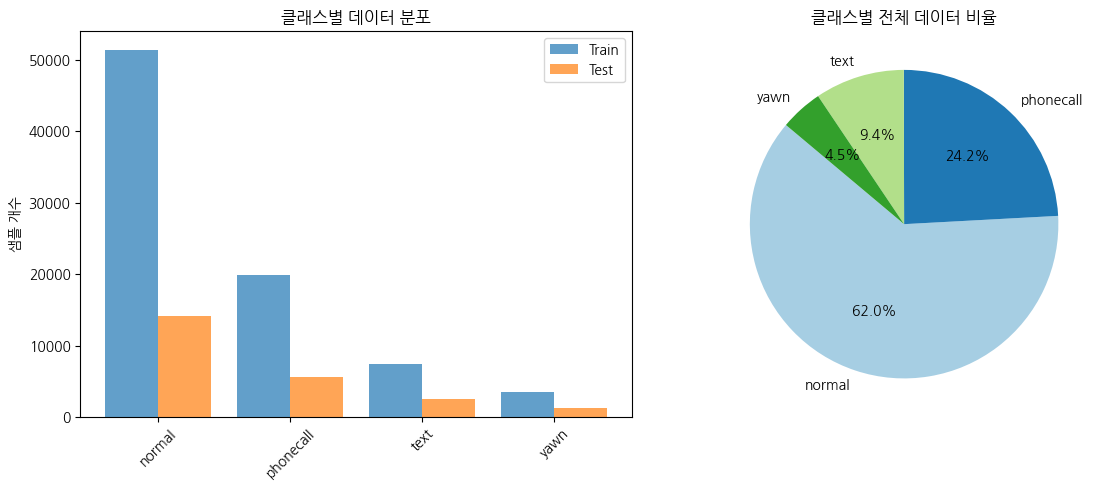

In [ ]:
visualize_data_distribution(train, test)

### DataLoader

In [ ]:
# DataLoader 설정
params = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True,
    "persistent_workers": True,
    "prefetch_factor": 2,
} if config["use_cuda"] else {}

In [ ]:
config["device"]

device(type='cuda')

In [ ]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset = TensorDataset(train_features, train_labels)
valid_dataset = TensorDataset(valid_features, valid_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, **params)
valid_loader = DataLoader(valid_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in valid_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 12, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 12, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 12, 5]) torch.Size([32])


In [ ]:
# Train, Test 라벨별 개수 확인
labels = train_labels.to(torch.long)#  Long 타입으로 변환
counts = torch.bincount(labels)
print(counts)

labels = valid_labels.to(torch.long)#  Long 타입으로 변환
counts = torch.bincount(labels)
print(counts)

labels = test_labels.to(torch.long)
counts = torch.bincount(labels)
print(counts)

tensor([4285, 1658,  613,  293])
tensor([1126,  448,  224,   74])
tensor([1175,  472,  214,  101])


## 1-3. LSTM 학습

In [ ]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self, config):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = config['feature_num']  # 특징 개수
        self.h_RNN_layers = config["RNN_hidden_layers"]
        self.h_RNN = config["RNN_hidden_nodes"]
        self.h_FC_dim = config["RNN_FC_dim"]
        self.drop_p = config["dropout_p"]
        self.num_classes = config["k"]

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        RNN_out, _ = self.LSTM(x_RNN, None)

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # 마지막 타임스텝a 사용
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x  # CrossEntropyLoss 사용 (Softmax 없음)

### optimizer

In [ ]:
device = config["device"]

In [ ]:
def get_optimizer(model, config):
    return optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

### 학습률 감소 스케줄러 설정
Test Loss 기준
- factor: 0.5, 학습률 50% 감소
- verbose: True, 감소된 경우 로그 출력

In [ ]:
def get_scheduler(optimizer, config):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=config["reduce_lr_factor"],
        patience=config["reduce_lr_patience"],
    )

### Early Stopping 설정

In [ ]:
early_stopping_patience = config["early_stopping_patience"]
best_loss = np.inf
patience_counter = 0

## 학습 진행

- Mixed Precision Training 유지 (torch.cuda.amp.autocast() + GradScaler())
-  Gradient Clipping 추가 (torch.nn.utils.clip_grad_norm_()) → 폭발적인 기울기(Gradient Explosion) 방지
- 모델 저장 기능 추가 (torch.save()) → Best Loss 갱신 시 자동 저장
- 학습률 스케줄러 로깅 추가 → ReduceLROnPlateau가 작동했는지 확인 가능

In [ ]:
def save_best_model(model, optimizer, epoch, best_loss, save_path):
    """Validation Loss가 가장 낮을 때만 모델을 저장하는 함수"""
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")  # 날짜 가져오기
    model_filename = f"{save_path}/best_model_{today_date}.pth"  # 저장 파일명

    # 기존 최적 모델 삭제 (이전 모델 유지 안 함)
    if os.path.exists(model_filename):
        os.remove(model_filename)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, model_filename)

    print(f"💾 Best Model Updated! Saved at {model_filename} (Loss: {best_loss:.4f})")

def save_training_results(
        epoch_train_losses,
        epoch_train_scores,
        epoch_test_losses,
        epoch_test_scores,
        save_path="./",
        ):
    """
    학습 과정의 손실(loss)과 정확도(score)를 저장하는 함수
    """
    os.makedirs(save_path, exist_ok=True)

    np.save(
        os.path.join(save_path, "LSTM_epoch_training_losses.npy"),
        np.array(epoch_train_losses),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_tsave_path, raining_scores.npy"),
        np.array(epoch_train_scores),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_loss.npy"), np.array(epoch_test_losses)
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_score.npy"),
        np.array(epoch_test_scores),
    )

### Train Dataset 평가
- 다음 기술을 적용하는 기준: Train data Loss
    - Early Stopping
    - 학습률 감소 스케줄러
    - 모델 저장 (Best Loss 갱신 시)

In [ ]:
# Mixed Precision Training을 위한 GradScaler 설정
scaler = torch.amp.GradScaler()

def train_model(model, train_loader, valid_loader, optimizer, criterion, scheduler, config):
    """
    Mixed Precision Training & Early Stopping 적용 학습 함수
    """
    model.to(config["device"])

    best_loss = np.inf  # Best Loss 초기화
    patience_counter = 0  # Early Stopping 카운터
    epoch_losses, epoch_scores = [], []  # Loss 및 Accuracy 저장용 리스트

    for epoch in range(config["epochs"]):
        model.train()
        losses, scores = [], []
        total_samples = 0

        # tqdm을 사용하여 학습 진행률 표시
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)

        for batch_idx, (X, y) in enumerate(progress_bar):
            X, y = X.to(config["device"]), y.to(config["device"]).long()

            # Mixed Precision Training 적용
            total_samples += X.size(0)
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast('cuda'): # 자동 Mixed Precision 사용
                output = model(X)  # LSTM 모델 Forward Pass
                loss = criterion(output, y)

            scaler.scale(loss).backward()  # Mixed Precision Backpropagation
            scaler.step(optimizer)  # 옵티마이저 업데이트
            scaler.update()  # Scaler 업데이트

            losses.append(loss.item())

            # 정확도 계산
            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

        avg_loss = sum(losses) / len(losses)
        avg_acc = sum(scores) / len(scores) * 100

        print(f"✅ Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

        # Loss 및 Accuracy 저장
        epoch_losses.append(avg_loss)
        epoch_scores.append(avg_acc)

        # 학습률 감소 스케줄러 업데이트 (`ReduceLROnPlateau` 사용 시 `min` 모드 적용)
        scheduler.step(avg_loss)
        if optimizer.param_groups[0]["lr"] != config["learning_rate"]:
            print(f"📉 Learning Rate Reduced: {optimizer.param_groups[0]['lr']:.6e}")

        # 모델 저장 (Best Loss 갱신 시)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0  # Early Stopping Counter 초기화
            save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])
            print(f"💾 Model Saved! New Best Loss: {best_loss:.4f}")
        else:
            patience_counter += 1

        # Early Stopping 체크
        if patience_counter >= early_stopping_patience:
            print(f"🚨 Early Stopping Triggered! Best Loss: {best_loss:.4f}")
            break

    return epoch_losses, epoch_scores

In [ ]:
def ensure_directory_exists(path):
    """주어진 경로의 폴더가 없으면 생성하는 함수"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"📂 Directory created: {path}")

In [ ]:
# 모델 저장 경로 설정
config["model_save_path"] = "/content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt"
config["train_result_path"] = "/content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_results"

# ✅ 경로 자동 생성 (존재하지 않으면 생성)
ensure_directory_exists(config["model_save_path"]) # 모델 저장 폴더
ensure_directory_exists(config["train_result_path"])  # 학습 결과 폴더

📂 Directory created: /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DecoderRNN(config)
model.to(device)  # 모델을 GPU로 이동

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

epoch_losses, epoch_scores = train_model(model, train_loader, valid_loader, optimizer, criterion, scheduler, config)

Epoch 1/100: 100%|██████████| 273/273 [00:03<00:00, 90.10it/s]


✅ Epoch 1 Finished - Avg Loss: 0.9549, Avg Acc: 63.06%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.9549)
💾 Model Saved! New Best Loss: 0.9549


Epoch 2/100: 100%|██████████| 273/273 [00:04<00:00, 65.41it/s]


✅ Epoch 2 Finished - Avg Loss: 0.6382, Avg Acc: 76.46%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.6382)
💾 Model Saved! New Best Loss: 0.6382


Epoch 3/100: 100%|██████████| 273/273 [00:02<00:00, 92.57it/s]


✅ Epoch 3 Finished - Avg Loss: 0.6053, Avg Acc: 79.07%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.6053)
💾 Model Saved! New Best Loss: 0.6053


Epoch 4/100: 100%|██████████| 273/273 [00:02<00:00, 92.32it/s]


✅ Epoch 4 Finished - Avg Loss: 0.5689, Avg Acc: 80.96%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.5689)
💾 Model Saved! New Best Loss: 0.5689


Epoch 5/100: 100%|██████████| 273/273 [00:03<00:00, 90.40it/s]


✅ Epoch 5 Finished - Avg Loss: 0.5474, Avg Acc: 81.40%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.5474)
💾 Model Saved! New Best Loss: 0.5474


Epoch 6/100: 100%|██████████| 273/273 [00:04<00:00, 66.20it/s]


✅ Epoch 6 Finished - Avg Loss: 0.5396, Avg Acc: 81.52%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.5396)
💾 Model Saved! New Best Loss: 0.5396


Epoch 7/100: 100%|██████████| 273/273 [00:02<00:00, 93.74it/s]


✅ Epoch 7 Finished - Avg Loss: 0.5276, Avg Acc: 81.63%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.5276)
💾 Model Saved! New Best Loss: 0.5276


Epoch 8/100: 100%|██████████| 273/273 [00:02<00:00, 93.99it/s]


✅ Epoch 8 Finished - Avg Loss: 0.5102, Avg Acc: 81.94%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.5102)
💾 Model Saved! New Best Loss: 0.5102


Epoch 9/100: 100%|██████████| 273/273 [00:02<00:00, 93.83it/s]


✅ Epoch 9 Finished - Avg Loss: 0.5015, Avg Acc: 82.24%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.5015)
💾 Model Saved! New Best Loss: 0.5015


Epoch 10/100: 100%|██████████| 273/273 [00:03<00:00, 68.47it/s]


✅ Epoch 10 Finished - Avg Loss: 0.4893, Avg Acc: 82.87%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4893)
💾 Model Saved! New Best Loss: 0.4893


Epoch 11/100: 100%|██████████| 273/273 [00:02<00:00, 95.09it/s]


✅ Epoch 11 Finished - Avg Loss: 0.4812, Avg Acc: 83.07%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4812)
💾 Model Saved! New Best Loss: 0.4812


Epoch 12/100: 100%|██████████| 273/273 [00:02<00:00, 93.37it/s]


✅ Epoch 12 Finished - Avg Loss: 0.4762, Avg Acc: 83.52%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4762)
💾 Model Saved! New Best Loss: 0.4762


Epoch 13/100: 100%|██████████| 273/273 [00:03<00:00, 88.66it/s]


✅ Epoch 13 Finished - Avg Loss: 0.4696, Avg Acc: 83.72%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4696)
💾 Model Saved! New Best Loss: 0.4696


Epoch 14/100: 100%|██████████| 273/273 [00:04<00:00, 67.07it/s]


✅ Epoch 14 Finished - Avg Loss: 0.4666, Avg Acc: 83.41%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4666)
💾 Model Saved! New Best Loss: 0.4666


Epoch 15/100: 100%|██████████| 273/273 [00:02<00:00, 93.25it/s]


✅ Epoch 15 Finished - Avg Loss: 0.4601, Avg Acc: 83.61%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4601)
💾 Model Saved! New Best Loss: 0.4601


Epoch 16/100: 100%|██████████| 273/273 [00:02<00:00, 92.89it/s]


✅ Epoch 16 Finished - Avg Loss: 0.4534, Avg Acc: 83.79%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4534)
💾 Model Saved! New Best Loss: 0.4534


Epoch 17/100: 100%|██████████| 273/273 [00:02<00:00, 94.40it/s]


✅ Epoch 17 Finished - Avg Loss: 0.4497, Avg Acc: 83.95%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4497)
💾 Model Saved! New Best Loss: 0.4497


Epoch 18/100: 100%|██████████| 273/273 [00:04<00:00, 67.99it/s]


✅ Epoch 18 Finished - Avg Loss: 0.4467, Avg Acc: 84.11%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4467)
💾 Model Saved! New Best Loss: 0.4467


Epoch 19/100: 100%|██████████| 273/273 [00:02<00:00, 93.17it/s]


✅ Epoch 19 Finished - Avg Loss: 0.4417, Avg Acc: 84.39%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4417)
💾 Model Saved! New Best Loss: 0.4417


Epoch 20/100: 100%|██████████| 273/273 [00:02<00:00, 92.61it/s]


✅ Epoch 20 Finished - Avg Loss: 0.4402, Avg Acc: 84.31%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4402)
💾 Model Saved! New Best Loss: 0.4402


Epoch 21/100: 100%|██████████| 273/273 [00:02<00:00, 92.48it/s]


✅ Epoch 21 Finished - Avg Loss: 0.4374, Avg Acc: 84.58%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4374)
💾 Model Saved! New Best Loss: 0.4374


Epoch 22/100: 100%|██████████| 273/273 [00:04<00:00, 68.13it/s]


✅ Epoch 22 Finished - Avg Loss: 0.4350, Avg Acc: 84.33%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4350)
💾 Model Saved! New Best Loss: 0.4350


Epoch 23/100: 100%|██████████| 273/273 [00:02<00:00, 92.08it/s]


✅ Epoch 23 Finished - Avg Loss: 0.4298, Avg Acc: 84.33%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4298)
💾 Model Saved! New Best Loss: 0.4298


Epoch 24/100: 100%|██████████| 273/273 [00:02<00:00, 92.75it/s]


✅ Epoch 24 Finished - Avg Loss: 0.4243, Avg Acc: 84.73%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4243)
💾 Model Saved! New Best Loss: 0.4243


Epoch 25/100: 100%|██████████| 273/273 [00:02<00:00, 93.17it/s]


✅ Epoch 25 Finished - Avg Loss: 0.4214, Avg Acc: 84.87%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4214)
💾 Model Saved! New Best Loss: 0.4214


Epoch 26/100: 100%|██████████| 273/273 [00:03<00:00, 69.76it/s]


✅ Epoch 26 Finished - Avg Loss: 0.4148, Avg Acc: 85.03%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4148)
💾 Model Saved! New Best Loss: 0.4148


Epoch 27/100: 100%|██████████| 273/273 [00:02<00:00, 93.44it/s]


✅ Epoch 27 Finished - Avg Loss: 0.4148, Avg Acc: 85.01%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4148)
💾 Model Saved! New Best Loss: 0.4148


Epoch 28/100: 100%|██████████| 273/273 [00:02<00:00, 92.80it/s]


✅ Epoch 28 Finished - Avg Loss: 0.4091, Avg Acc: 85.68%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4091)
💾 Model Saved! New Best Loss: 0.4091


Epoch 29/100: 100%|██████████| 273/273 [00:02<00:00, 93.70it/s]


✅ Epoch 29 Finished - Avg Loss: 0.4083, Avg Acc: 85.29%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4083)
💾 Model Saved! New Best Loss: 0.4083


Epoch 30/100: 100%|██████████| 273/273 [00:03<00:00, 69.78it/s]


✅ Epoch 30 Finished - Avg Loss: 0.4043, Avg Acc: 85.28%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4043)
💾 Model Saved! New Best Loss: 0.4043


Epoch 31/100: 100%|██████████| 273/273 [00:02<00:00, 94.88it/s]


✅ Epoch 31 Finished - Avg Loss: 0.4003, Avg Acc: 85.75%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.4003)
💾 Model Saved! New Best Loss: 0.4003


Epoch 32/100: 100%|██████████| 273/273 [00:02<00:00, 92.68it/s]


✅ Epoch 32 Finished - Avg Loss: 0.3946, Avg Acc: 85.76%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3946)
💾 Model Saved! New Best Loss: 0.3946


Epoch 33/100: 100%|██████████| 273/273 [00:02<00:00, 93.95it/s]


✅ Epoch 33 Finished - Avg Loss: 0.3921, Avg Acc: 85.90%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3921)
💾 Model Saved! New Best Loss: 0.3921


Epoch 34/100: 100%|██████████| 273/273 [00:03<00:00, 68.33it/s]


✅ Epoch 34 Finished - Avg Loss: 0.3917, Avg Acc: 86.00%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3917)
💾 Model Saved! New Best Loss: 0.3917


Epoch 35/100: 100%|██████████| 273/273 [00:02<00:00, 95.33it/s]


✅ Epoch 35 Finished - Avg Loss: 0.3846, Avg Acc: 86.16%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3846)
💾 Model Saved! New Best Loss: 0.3846


Epoch 36/100: 100%|██████████| 273/273 [00:02<00:00, 95.05it/s]


✅ Epoch 36 Finished - Avg Loss: 0.3861, Avg Acc: 86.15%


Epoch 37/100: 100%|██████████| 273/273 [00:02<00:00, 91.84it/s]


✅ Epoch 37 Finished - Avg Loss: 0.3813, Avg Acc: 86.20%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3813)
💾 Model Saved! New Best Loss: 0.3813


Epoch 38/100: 100%|██████████| 273/273 [00:04<00:00, 68.06it/s]


✅ Epoch 38 Finished - Avg Loss: 0.3811, Avg Acc: 86.27%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3811)
💾 Model Saved! New Best Loss: 0.3811


Epoch 39/100: 100%|██████████| 273/273 [00:02<00:00, 91.90it/s]


✅ Epoch 39 Finished - Avg Loss: 0.3737, Avg Acc: 86.20%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3737)
💾 Model Saved! New Best Loss: 0.3737


Epoch 40/100: 100%|██████████| 273/273 [00:02<00:00, 93.52it/s]


✅ Epoch 40 Finished - Avg Loss: 0.3757, Avg Acc: 86.39%


Epoch 41/100: 100%|██████████| 273/273 [00:02<00:00, 94.16it/s]


✅ Epoch 41 Finished - Avg Loss: 0.3716, Avg Acc: 86.24%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3716)
💾 Model Saved! New Best Loss: 0.3716


Epoch 42/100: 100%|██████████| 273/273 [00:04<00:00, 68.22it/s]


✅ Epoch 42 Finished - Avg Loss: 0.3712, Avg Acc: 86.55%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3712)
💾 Model Saved! New Best Loss: 0.3712


Epoch 43/100: 100%|██████████| 273/273 [00:02<00:00, 93.36it/s]


✅ Epoch 43 Finished - Avg Loss: 0.3654, Avg Acc: 86.55%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3654)
💾 Model Saved! New Best Loss: 0.3654


Epoch 44/100: 100%|██████████| 273/273 [00:02<00:00, 94.42it/s]


✅ Epoch 44 Finished - Avg Loss: 0.3656, Avg Acc: 86.53%


Epoch 45/100: 100%|██████████| 273/273 [00:03<00:00, 72.60it/s]


✅ Epoch 45 Finished - Avg Loss: 0.3578, Avg Acc: 86.85%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3578)
💾 Model Saved! New Best Loss: 0.3578


Epoch 46/100: 100%|██████████| 273/273 [00:05<00:00, 46.91it/s]


✅ Epoch 46 Finished - Avg Loss: 0.3596, Avg Acc: 86.85%


Epoch 47/100: 100%|██████████| 273/273 [00:03<00:00, 89.66it/s]


✅ Epoch 47 Finished - Avg Loss: 0.3558, Avg Acc: 86.84%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3558)
💾 Model Saved! New Best Loss: 0.3558


Epoch 48/100: 100%|██████████| 273/273 [00:02<00:00, 95.12it/s]


✅ Epoch 48 Finished - Avg Loss: 0.3537, Avg Acc: 86.90%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3537)
💾 Model Saved! New Best Loss: 0.3537


Epoch 49/100: 100%|██████████| 273/273 [00:03<00:00, 78.40it/s]


✅ Epoch 49 Finished - Avg Loss: 0.3528, Avg Acc: 87.00%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3528)
💾 Model Saved! New Best Loss: 0.3528


Epoch 50/100: 100%|██████████| 273/273 [00:03<00:00, 80.29it/s]


✅ Epoch 50 Finished - Avg Loss: 0.3463, Avg Acc: 87.18%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3463)
💾 Model Saved! New Best Loss: 0.3463


Epoch 51/100: 100%|██████████| 273/273 [00:02<00:00, 94.08it/s]


✅ Epoch 51 Finished - Avg Loss: 0.3449, Avg Acc: 87.04%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3449)
💾 Model Saved! New Best Loss: 0.3449


Epoch 52/100: 100%|██████████| 273/273 [00:02<00:00, 94.41it/s]


✅ Epoch 52 Finished - Avg Loss: 0.3455, Avg Acc: 87.20%


Epoch 53/100: 100%|██████████| 273/273 [00:03<00:00, 83.93it/s]


✅ Epoch 53 Finished - Avg Loss: 0.3463, Avg Acc: 87.01%


Epoch 54/100: 100%|██████████| 273/273 [00:04<00:00, 60.80it/s]


✅ Epoch 54 Finished - Avg Loss: 0.3370, Avg Acc: 87.45%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3370)
💾 Model Saved! New Best Loss: 0.3370


Epoch 55/100: 100%|██████████| 273/273 [00:04<00:00, 64.27it/s]


✅ Epoch 55 Finished - Avg Loss: 0.3372, Avg Acc: 87.43%


Epoch 56/100: 100%|██████████| 273/273 [00:03<00:00, 75.04it/s]


✅ Epoch 56 Finished - Avg Loss: 0.3308, Avg Acc: 87.82%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3308)
💾 Model Saved! New Best Loss: 0.3308


Epoch 57/100: 100%|██████████| 273/273 [00:03<00:00, 69.39it/s]


✅ Epoch 57 Finished - Avg Loss: 0.3318, Avg Acc: 87.45%


Epoch 58/100: 100%|██████████| 273/273 [00:03<00:00, 86.45it/s]


✅ Epoch 58 Finished - Avg Loss: 0.3264, Avg Acc: 87.58%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3264)
💾 Model Saved! New Best Loss: 0.3264


Epoch 59/100: 100%|██████████| 273/273 [00:02<00:00, 92.64it/s]


✅ Epoch 59 Finished - Avg Loss: 0.3229, Avg Acc: 87.94%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3229)
💾 Model Saved! New Best Loss: 0.3229


Epoch 60/100: 100%|██████████| 273/273 [00:03<00:00, 86.61it/s]


✅ Epoch 60 Finished - Avg Loss: 0.3194, Avg Acc: 87.95%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3194)
💾 Model Saved! New Best Loss: 0.3194


Epoch 61/100: 100%|██████████| 273/273 [00:03<00:00, 72.85it/s]


✅ Epoch 61 Finished - Avg Loss: 0.3176, Avg Acc: 88.39%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3176)
💾 Model Saved! New Best Loss: 0.3176


Epoch 62/100: 100%|██████████| 273/273 [00:02<00:00, 93.10it/s]


✅ Epoch 62 Finished - Avg Loss: 0.3153, Avg Acc: 88.18%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3153)
💾 Model Saved! New Best Loss: 0.3153


Epoch 63/100: 100%|██████████| 273/273 [00:02<00:00, 93.49it/s]


✅ Epoch 63 Finished - Avg Loss: 0.3142, Avg Acc: 88.17%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3142)
💾 Model Saved! New Best Loss: 0.3142


Epoch 64/100: 100%|██████████| 273/273 [00:03<00:00, 88.58it/s]


✅ Epoch 64 Finished - Avg Loss: 0.3060, Avg Acc: 88.49%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3060)
💾 Model Saved! New Best Loss: 0.3060


Epoch 65/100: 100%|██████████| 273/273 [00:03<00:00, 73.25it/s]


✅ Epoch 65 Finished - Avg Loss: 0.3058, Avg Acc: 88.55%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.3058)
💾 Model Saved! New Best Loss: 0.3058


Epoch 66/100: 100%|██████████| 273/273 [00:02<00:00, 92.20it/s]


✅ Epoch 66 Finished - Avg Loss: 0.2985, Avg Acc: 88.63%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2985)
💾 Model Saved! New Best Loss: 0.2985


Epoch 67/100: 100%|██████████| 273/273 [00:02<00:00, 91.87it/s]


✅ Epoch 67 Finished - Avg Loss: 0.3025, Avg Acc: 88.39%


Epoch 68/100: 100%|██████████| 273/273 [00:03<00:00, 87.62it/s]


✅ Epoch 68 Finished - Avg Loss: 0.2931, Avg Acc: 88.93%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2931)
💾 Model Saved! New Best Loss: 0.2931


Epoch 69/100: 100%|██████████| 273/273 [00:03<00:00, 72.20it/s]


✅ Epoch 69 Finished - Avg Loss: 0.2953, Avg Acc: 88.92%


Epoch 70/100: 100%|██████████| 273/273 [00:02<00:00, 92.94it/s]


✅ Epoch 70 Finished - Avg Loss: 0.2879, Avg Acc: 89.30%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2879)
💾 Model Saved! New Best Loss: 0.2879


Epoch 71/100: 100%|██████████| 273/273 [00:02<00:00, 93.48it/s]


✅ Epoch 71 Finished - Avg Loss: 0.2875, Avg Acc: 89.31%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2875)
💾 Model Saved! New Best Loss: 0.2875


Epoch 72/100: 100%|██████████| 273/273 [00:03<00:00, 89.28it/s]


✅ Epoch 72 Finished - Avg Loss: 0.2797, Avg Acc: 89.37%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2797)
💾 Model Saved! New Best Loss: 0.2797


Epoch 73/100: 100%|██████████| 273/273 [00:03<00:00, 71.06it/s]


✅ Epoch 73 Finished - Avg Loss: 0.2788, Avg Acc: 89.31%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2788)
💾 Model Saved! New Best Loss: 0.2788


Epoch 74/100: 100%|██████████| 273/273 [00:02<00:00, 93.56it/s]


✅ Epoch 74 Finished - Avg Loss: 0.2771, Avg Acc: 89.54%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2771)
💾 Model Saved! New Best Loss: 0.2771


Epoch 75/100: 100%|██████████| 273/273 [00:02<00:00, 91.97it/s]


✅ Epoch 75 Finished - Avg Loss: 0.2703, Avg Acc: 89.62%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2703)
💾 Model Saved! New Best Loss: 0.2703


Epoch 76/100: 100%|██████████| 273/273 [00:03<00:00, 90.16it/s]


✅ Epoch 76 Finished - Avg Loss: 0.2709, Avg Acc: 89.48%


Epoch 77/100: 100%|██████████| 273/273 [00:04<00:00, 67.03it/s]


✅ Epoch 77 Finished - Avg Loss: 0.2722, Avg Acc: 89.85%


Epoch 78/100: 100%|██████████| 273/273 [00:03<00:00, 86.81it/s]


✅ Epoch 78 Finished - Avg Loss: 0.2666, Avg Acc: 89.76%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2666)
💾 Model Saved! New Best Loss: 0.2666


Epoch 79/100: 100%|██████████| 273/273 [00:03<00:00, 89.00it/s]


✅ Epoch 79 Finished - Avg Loss: 0.2608, Avg Acc: 90.09%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2608)
💾 Model Saved! New Best Loss: 0.2608


Epoch 80/100: 100%|██████████| 273/273 [00:03<00:00, 84.26it/s]


✅ Epoch 80 Finished - Avg Loss: 0.2568, Avg Acc: 90.20%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2568)
💾 Model Saved! New Best Loss: 0.2568


Epoch 81/100: 100%|██████████| 273/273 [00:03<00:00, 71.30it/s]


✅ Epoch 81 Finished - Avg Loss: 0.2516, Avg Acc: 90.22%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2516)
💾 Model Saved! New Best Loss: 0.2516


Epoch 82/100: 100%|██████████| 273/273 [00:03<00:00, 90.70it/s]


✅ Epoch 82 Finished - Avg Loss: 0.2470, Avg Acc: 90.45%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2470)
💾 Model Saved! New Best Loss: 0.2470


Epoch 83/100: 100%|██████████| 273/273 [00:02<00:00, 94.56it/s]


✅ Epoch 83 Finished - Avg Loss: 0.2438, Avg Acc: 90.71%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2438)
💾 Model Saved! New Best Loss: 0.2438


Epoch 84/100: 100%|██████████| 273/273 [00:03<00:00, 84.42it/s]


✅ Epoch 84 Finished - Avg Loss: 0.2404, Avg Acc: 90.74%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2404)
💾 Model Saved! New Best Loss: 0.2404


Epoch 85/100: 100%|██████████| 273/273 [00:04<00:00, 65.55it/s]


✅ Epoch 85 Finished - Avg Loss: 0.2360, Avg Acc: 90.97%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2360)
💾 Model Saved! New Best Loss: 0.2360


Epoch 86/100: 100%|██████████| 273/273 [00:02<00:00, 94.29it/s]


✅ Epoch 86 Finished - Avg Loss: 0.2305, Avg Acc: 90.95%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2305)
💾 Model Saved! New Best Loss: 0.2305


Epoch 87/100: 100%|██████████| 273/273 [00:02<00:00, 91.71it/s]


✅ Epoch 87 Finished - Avg Loss: 0.2294, Avg Acc: 90.94%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2294)
💾 Model Saved! New Best Loss: 0.2294


Epoch 88/100: 100%|██████████| 273/273 [00:03<00:00, 80.08it/s]


✅ Epoch 88 Finished - Avg Loss: 0.2223, Avg Acc: 91.42%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2223)
💾 Model Saved! New Best Loss: 0.2223


Epoch 89/100: 100%|██████████| 273/273 [00:03<00:00, 77.38it/s]


✅ Epoch 89 Finished - Avg Loss: 0.2227, Avg Acc: 91.08%


Epoch 90/100: 100%|██████████| 273/273 [00:03<00:00, 90.72it/s]


✅ Epoch 90 Finished - Avg Loss: 0.2191, Avg Acc: 91.43%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2191)
💾 Model Saved! New Best Loss: 0.2191


Epoch 91/100: 100%|██████████| 273/273 [00:02<00:00, 93.21it/s]


✅ Epoch 91 Finished - Avg Loss: 0.2197, Avg Acc: 91.51%


Epoch 92/100: 100%|██████████| 273/273 [00:03<00:00, 80.50it/s]


✅ Epoch 92 Finished - Avg Loss: 0.2074, Avg Acc: 91.99%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2074)
💾 Model Saved! New Best Loss: 0.2074


Epoch 93/100: 100%|██████████| 273/273 [00:03<00:00, 72.77it/s]


✅ Epoch 93 Finished - Avg Loss: 0.2095, Avg Acc: 91.99%


Epoch 94/100: 100%|██████████| 273/273 [00:03<00:00, 87.12it/s]


✅ Epoch 94 Finished - Avg Loss: 0.2036, Avg Acc: 91.98%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.2036)
💾 Model Saved! New Best Loss: 0.2036


Epoch 95/100: 100%|██████████| 273/273 [00:02<00:00, 94.22it/s]


✅ Epoch 95 Finished - Avg Loss: 0.1913, Avg Acc: 92.80%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.1913)
💾 Model Saved! New Best Loss: 0.1913


Epoch 96/100: 100%|██████████| 273/273 [00:03<00:00, 78.39it/s]


✅ Epoch 96 Finished - Avg Loss: 0.1962, Avg Acc: 92.60%


Epoch 97/100: 100%|██████████| 273/273 [00:03<00:00, 77.54it/s]


✅ Epoch 97 Finished - Avg Loss: 0.1921, Avg Acc: 92.32%


Epoch 98/100: 100%|██████████| 273/273 [00:03<00:00, 88.61it/s]


✅ Epoch 98 Finished - Avg Loss: 0.1802, Avg Acc: 93.04%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.1802)
💾 Model Saved! New Best Loss: 0.1802


Epoch 99/100: 100%|██████████| 273/273 [00:02<00:00, 91.91it/s]


✅ Epoch 99 Finished - Avg Loss: 0.1787, Avg Acc: 93.01%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.1787)
💾 Model Saved! New Best Loss: 0.1787


Epoch 100/100: 100%|██████████| 273/273 [00:03<00:00, 82.01it/s]


✅ Epoch 100 Finished - Avg Loss: 0.1727, Avg Acc: 93.36%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_ckpt/best_model_2025-03-16.pth (Loss: 0.1727)
💾 Model Saved! New Best Loss: 0.1727


### Train, Validation Dataset 평가
- 다음 기술을 적용하는 기준: Test data Loss
    - Early Stopping
    - 학습률 감소 스케줄러
    - 모델 저장 (Best Loss 갱신 시)

In [ ]:
# Mixed Precision Training을 위한 GradScaler 설정
scaler = torch.amp.GradScaler()

# 학습 결과 저장 함수
def save_training_results(epoch, train_losses, train_scores, test_losses, test_scores, save_path):
    """학습 결과를 CSV 파일로 저장하는 함수"""
    results_df = pd.DataFrame({
        "epoch": list(range(1, epoch + 2)),
        "train_loss": train_losses,
        "train_accuracy": train_scores,
        "test_loss": test_losses,
        "test_accuracy": test_scores,
    })

    results_df.to_csv(f"{save_path}/training_results.csv", index=False)
    print(f"💾 Training results saved at {save_path}/training_results.csv")

# 학습 함수
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    losses, scores = [], []
    total_samples = 0

    # tqdm을 사용하여 학습 진행률 표시
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)

    for batch_idx, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device).long()
        total_samples += X.size(0)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda'):
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #  Gradient Clipping
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        # 정확도 계산
        y_pred = torch.argmax(output, dim=1)
        acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
        scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Train Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # 학습 Loss 및 Accuracy 반환

# 검증 함수
def validate(model, device, criterion, test_loader, model_save_path, optimizer, epoch):
    model.eval()
    losses, scores = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).long()

            with torch.amp.autocast(device_type='cuda'):
                output = model(X)
                loss = criterion(output, y)

            losses.append(loss.item())

            # 정확도 계산
            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Validation Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")
    # 모델 저장 기능(옵셔널)
    if model_save_path and optimizer:
        save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])

    return avg_loss, avg_acc  # 검증 Loss 및 Accuracy 반환


In [ ]:
# 전체 학습 실행 코드
def train_and_validate(model, train_loader, valid_loader, optimizer, criterion, scheduler, config):
    best_loss = np.inf  # Best Loss 초기화
    patience_counter = 0  # Early Stopping 카운터

    epoch_train_losses, epoch_train_scores = [], []
    epoch_valid_losses, epoch_valid_scores = [], []
    config['early_stopping_patience'] = 10

    for epoch in range(config["epochs"]):
        # 학습 단계
        epoch_train_loss, epoch_train_score = train(
            config["log_interval"], model, config["device"], train_loader, optimizer, criterion, epoch
        )

        # 검증 단계
        epoch_valid_loss, epoch_valid_score = validate(
            model, config["device"], criterion, valid_loader, None, None, epoch
        )

        # 결과 저장
        epoch_train_losses.append(epoch_train_loss)
        epoch_train_scores.append(epoch_train_score)
        epoch_valid_losses.append(epoch_valid_loss)
        epoch_valid_scores.append(epoch_valid_score)

        # 학습률 감소 적용
        scheduler.step(epoch_valid_loss)

        # Early Stopping 체크
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            patience_counter = 0  # 개선되었으므로 patience 초기화

            save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])
            print(f"💾 Model Saved! New Best Loss: {best_loss:.4f}")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping 대기 카운트: {patience_counter}/{config['early_stopping_patience']}")

        # 설정된 patience 횟수만큼 개선되지 않으면 학습 중단
        if patience_counter >= config["early_stopping_patience"]:
            print("⏹️ Early stopping 적용됨. 학습 종료.")
            break  # 학습 중단

        # 학습 결과 저장
        save_training_results(
            epoch,
            epoch_train_losses,
            epoch_train_scores,
            epoch_valid_losses,
            epoch_valid_scores,
            save_path=config["train_result_path"],
        )

    return epoch_train_losses, epoch_train_scores, epoch_valid_losses, epoch_valid_scores

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DecoderRNN(config)
model.to(device)  # 모델을 GPU로 이동

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

epoch_train_losses, epoch_train_scores, epoch_valid_losses, epoch_valid_scores = train_and_validate(model, train_loader, valid_loader, optimizer, criterion, scheduler, config)
# RuntimeError: DataLoader worker -> dataloader 재실행

Epoch 1/100: 100%|██████████| 215/215 [00:03<00:00, 67.76it/s]


✅ Train Epoch 1 Finished - Avg Loss: 1.2343, Avg Acc: 46.79%
✅ Validation Finished - Avg Loss: 1.0394, Avg Acc: 60.17%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 1.0394)
💾 Model Saved! New Best Loss: 1.0394
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 2/100: 100%|██████████| 215/215 [00:02<00:00, 85.95it/s]


✅ Train Epoch 2 Finished - Avg Loss: 0.9899, Avg Acc: 62.28%
✅ Validation Finished - Avg Loss: 1.0120, Avg Acc: 60.17%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 1.0120)
💾 Model Saved! New Best Loss: 1.0120
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 3/100: 100%|██████████| 215/215 [00:02<00:00, 86.79it/s]


✅ Train Epoch 3 Finished - Avg Loss: 0.9029, Avg Acc: 64.55%
✅ Validation Finished - Avg Loss: 0.8637, Avg Acc: 73.46%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.8637)
💾 Model Saved! New Best Loss: 0.8637
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 4/100: 100%|██████████| 215/215 [00:02<00:00, 88.08it/s]


✅ Train Epoch 4 Finished - Avg Loss: 0.7721, Avg Acc: 73.74%
✅ Validation Finished - Avg Loss: 0.7979, Avg Acc: 72.56%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.7979)
💾 Model Saved! New Best Loss: 0.7979
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 5/100: 100%|██████████| 215/215 [00:03<00:00, 64.28it/s]


✅ Train Epoch 5 Finished - Avg Loss: 0.7054, Avg Acc: 75.39%
✅ Validation Finished - Avg Loss: 0.7283, Avg Acc: 74.63%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.7283)
💾 Model Saved! New Best Loss: 0.7283
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 6/100: 100%|██████████| 215/215 [00:02<00:00, 85.74it/s]


✅ Train Epoch 6 Finished - Avg Loss: 0.6702, Avg Acc: 76.41%
✅ Validation Finished - Avg Loss: 0.6844, Avg Acc: 77.07%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.6844)
💾 Model Saved! New Best Loss: 0.6844
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 7/100: 100%|██████████| 215/215 [00:02<00:00, 88.40it/s]


✅ Train Epoch 7 Finished - Avg Loss: 0.5883, Avg Acc: 79.65%
✅ Validation Finished - Avg Loss: 0.6186, Avg Acc: 80.24%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.6186)
💾 Model Saved! New Best Loss: 0.6186
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 8/100: 100%|██████████| 215/215 [00:02<00:00, 86.94it/s]


✅ Train Epoch 8 Finished - Avg Loss: 0.5510, Avg Acc: 81.34%
✅ Validation Finished - Avg Loss: 0.5951, Avg Acc: 80.93%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5951)
💾 Model Saved! New Best Loss: 0.5951
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 9/100: 100%|██████████| 215/215 [00:03<00:00, 71.38it/s]


✅ Train Epoch 9 Finished - Avg Loss: 0.5450, Avg Acc: 81.53%
✅ Validation Finished - Avg Loss: 0.5965, Avg Acc: 80.77%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 10/100: 100%|██████████| 215/215 [00:03<00:00, 71.56it/s]


✅ Train Epoch 10 Finished - Avg Loss: 0.5402, Avg Acc: 81.28%
✅ Validation Finished - Avg Loss: 0.5931, Avg Acc: 81.20%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5931)
💾 Model Saved! New Best Loss: 0.5931
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 11/100: 100%|██████████| 215/215 [00:02<00:00, 88.14it/s]


✅ Train Epoch 11 Finished - Avg Loss: 0.5393, Avg Acc: 81.69%
✅ Validation Finished - Avg Loss: 0.5907, Avg Acc: 80.72%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5907)
💾 Model Saved! New Best Loss: 0.5907
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 12/100: 100%|██████████| 215/215 [00:02<00:00, 89.17it/s]


✅ Train Epoch 12 Finished - Avg Loss: 0.5348, Avg Acc: 81.53%
✅ Validation Finished - Avg Loss: 0.5946, Avg Acc: 80.99%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 13/100: 100%|██████████| 215/215 [00:02<00:00, 86.20it/s]


✅ Train Epoch 13 Finished - Avg Loss: 0.5328, Avg Acc: 81.80%
✅ Validation Finished - Avg Loss: 0.5757, Avg Acc: 81.41%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5757)
💾 Model Saved! New Best Loss: 0.5757
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 14/100: 100%|██████████| 215/215 [00:03<00:00, 64.03it/s]


✅ Train Epoch 14 Finished - Avg Loss: 0.5301, Avg Acc: 81.83%
✅ Validation Finished - Avg Loss: 0.5704, Avg Acc: 81.51%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5704)
💾 Model Saved! New Best Loss: 0.5704
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 15/100: 100%|██████████| 215/215 [00:02<00:00, 87.29it/s]


✅ Train Epoch 15 Finished - Avg Loss: 0.5369, Avg Acc: 81.42%
✅ Validation Finished - Avg Loss: 0.5749, Avg Acc: 81.36%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 16/100: 100%|██████████| 215/215 [00:02<00:00, 87.75it/s]


✅ Train Epoch 16 Finished - Avg Loss: 0.5290, Avg Acc: 81.45%
✅ Validation Finished - Avg Loss: 0.5876, Avg Acc: 80.72%
⏳ Early stopping 대기 카운트: 2/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 17/100: 100%|██████████| 215/215 [00:02<00:00, 86.16it/s]


✅ Train Epoch 17 Finished - Avg Loss: 0.5252, Avg Acc: 81.95%
✅ Validation Finished - Avg Loss: 0.5679, Avg Acc: 81.46%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5679)
💾 Model Saved! New Best Loss: 0.5679
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 18/100: 100%|██████████| 215/215 [00:03<00:00, 59.80it/s]


✅ Train Epoch 18 Finished - Avg Loss: 0.5216, Avg Acc: 81.92%
✅ Validation Finished - Avg Loss: 0.5856, Avg Acc: 80.46%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 19/100: 100%|██████████| 215/215 [00:02<00:00, 88.57it/s]


✅ Train Epoch 19 Finished - Avg Loss: 0.5167, Avg Acc: 82.09%
✅ Validation Finished - Avg Loss: 0.5722, Avg Acc: 80.88%
⏳ Early stopping 대기 카운트: 2/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 20/100: 100%|██████████| 215/215 [00:02<00:00, 87.78it/s]


✅ Train Epoch 20 Finished - Avg Loss: 0.5170, Avg Acc: 82.09%
✅ Validation Finished - Avg Loss: 0.5596, Avg Acc: 81.67%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5596)
💾 Model Saved! New Best Loss: 0.5596
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 21/100: 100%|██████████| 215/215 [00:02<00:00, 79.77it/s]


✅ Train Epoch 21 Finished - Avg Loss: 0.5249, Avg Acc: 81.56%
✅ Validation Finished - Avg Loss: 0.5743, Avg Acc: 80.99%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 22/100: 100%|██████████| 215/215 [00:03<00:00, 71.43it/s]


✅ Train Epoch 22 Finished - Avg Loss: 0.5149, Avg Acc: 81.93%
✅ Validation Finished - Avg Loss: 0.5811, Avg Acc: 80.35%
⏳ Early stopping 대기 카운트: 2/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 23/100: 100%|██████████| 215/215 [00:03<00:00, 65.74it/s]


✅ Train Epoch 23 Finished - Avg Loss: 0.5153, Avg Acc: 82.15%
✅ Validation Finished - Avg Loss: 0.5469, Avg Acc: 82.26%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5469)
💾 Model Saved! New Best Loss: 0.5469
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 24/100: 100%|██████████| 215/215 [00:02<00:00, 87.65it/s]


✅ Train Epoch 24 Finished - Avg Loss: 0.5170, Avg Acc: 82.02%
✅ Validation Finished - Avg Loss: 0.5663, Avg Acc: 81.09%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 25/100: 100%|██████████| 215/215 [00:02<00:00, 86.06it/s]


✅ Train Epoch 25 Finished - Avg Loss: 0.5121, Avg Acc: 82.27%
✅ Validation Finished - Avg Loss: 0.5451, Avg Acc: 82.04%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5451)
💾 Model Saved! New Best Loss: 0.5451
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 26/100: 100%|██████████| 215/215 [00:02<00:00, 82.01it/s]


✅ Train Epoch 26 Finished - Avg Loss: 0.5124, Avg Acc: 82.01%
✅ Validation Finished - Avg Loss: 0.5741, Avg Acc: 80.51%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 27/100: 100%|██████████| 215/215 [00:03<00:00, 65.62it/s]


✅ Train Epoch 27 Finished - Avg Loss: 0.5105, Avg Acc: 82.03%
✅ Validation Finished - Avg Loss: 0.5430, Avg Acc: 82.20%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5430)
💾 Model Saved! New Best Loss: 0.5430
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 28/100: 100%|██████████| 215/215 [00:02<00:00, 84.13it/s]


✅ Train Epoch 28 Finished - Avg Loss: 0.5084, Avg Acc: 82.14%
✅ Validation Finished - Avg Loss: 0.5418, Avg Acc: 82.10%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-17.pth (Loss: 0.5418)
💾 Model Saved! New Best Loss: 0.5418
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 29/100: 100%|██████████| 215/215 [00:02<00:00, 87.37it/s]


✅ Train Epoch 29 Finished - Avg Loss: 0.5131, Avg Acc: 82.02%
✅ Validation Finished - Avg Loss: 0.5582, Avg Acc: 81.51%
⏳ Early stopping 대기 카운트: 1/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 30/100: 100%|██████████| 215/215 [00:03<00:00, 60.28it/s]


✅ Train Epoch 30 Finished - Avg Loss: 0.5069, Avg Acc: 82.14%
✅ Validation Finished - Avg Loss: 0.5563, Avg Acc: 81.73%
⏳ Early stopping 대기 카운트: 2/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 31/100: 100%|██████████| 215/215 [00:03<00:00, 60.76it/s]


✅ Train Epoch 31 Finished - Avg Loss: 0.5078, Avg Acc: 82.05%
✅ Validation Finished - Avg Loss: 0.5494, Avg Acc: 81.89%
⏳ Early stopping 대기 카운트: 3/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 32/100: 100%|██████████| 215/215 [00:02<00:00, 87.05it/s]


✅ Train Epoch 32 Finished - Avg Loss: 0.5066, Avg Acc: 82.19%
✅ Validation Finished - Avg Loss: 0.5601, Avg Acc: 81.20%
⏳ Early stopping 대기 카운트: 4/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 33/100: 100%|██████████| 215/215 [00:02<00:00, 88.30it/s]


✅ Train Epoch 33 Finished - Avg Loss: 0.5053, Avg Acc: 82.22%
✅ Validation Finished - Avg Loss: 0.5633, Avg Acc: 80.99%
⏳ Early stopping 대기 카운트: 5/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 34/100: 100%|██████████| 215/215 [00:02<00:00, 87.39it/s]


✅ Train Epoch 34 Finished - Avg Loss: 0.5103, Avg Acc: 81.69%
✅ Validation Finished - Avg Loss: 0.5568, Avg Acc: 81.67%
⏳ Early stopping 대기 카운트: 6/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 35/100: 100%|██████████| 215/215 [00:03<00:00, 62.61it/s]


✅ Train Epoch 35 Finished - Avg Loss: 0.5053, Avg Acc: 82.22%
✅ Validation Finished - Avg Loss: 0.5443, Avg Acc: 82.04%
⏳ Early stopping 대기 카운트: 7/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 36/100: 100%|██████████| 215/215 [00:02<00:00, 86.58it/s]


✅ Train Epoch 36 Finished - Avg Loss: 0.5032, Avg Acc: 82.25%
✅ Validation Finished - Avg Loss: 0.5584, Avg Acc: 81.57%
⏳ Early stopping 대기 카운트: 8/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 37/100: 100%|██████████| 215/215 [00:02<00:00, 85.02it/s]


✅ Train Epoch 37 Finished - Avg Loss: 0.5011, Avg Acc: 82.25%
✅ Validation Finished - Avg Loss: 0.5432, Avg Acc: 82.26%
⏳ Early stopping 대기 카운트: 9/10
💾 Training results saved at /content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.csv


Epoch 38/100: 100%|██████████| 215/215 [00:02<00:00, 87.29it/s]


✅ Train Epoch 38 Finished - Avg Loss: 0.5023, Avg Acc: 82.37%
✅ Validation Finished - Avg Loss: 0.5533, Avg Acc: 81.78%
⏳ Early stopping 대기 카운트: 10/10
⏹️ Early stopping 적용됨. 학습 종료.


## 결과 시각화

In [ ]:
# Train 성능 평가만 할 경우
def plot_train_results(epoch_losses, epoch_scores, save_path="./"):
    """
    학습 과정의 Loss 및 Accuracy를 시각화하는 함수 (Train만).
    """
    os.makedirs(save_path, exist_ok=True)

    A = np.array(epoch_losses)
    B = np.array(epoch_scores)

    fig = plt.figure(figsize=(10, 4))

    # Loss 그래프
    plt.subplot(121)
    plt.plot(np.arange(1, len(A) + 1), A, marker="o", markersize=2, linestyle="-", label="Train Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    # plt.ylim((0, max(2, max(A)))) # Y축 범위 설정

    # Accuracy 그래프
    plt.subplot(122)
    plt.plot(np.arange(1, len(B) + 1), B, marker="o", markersize=2, linestyle="-", label="Train Accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="upper left")
    # plt.ylim((0, 100))

    # 그래프 저장
    plot_save_path = os.path.join(save_path, "train_results.png")
    plt.savefig(plot_save_path, dpi=600)
    plt.show()

    print(f"\n✅ 학습 그래프 저장 완료 ({plot_save_path})\n")

# Train - Test 성능 평가 (Train + Validation)
def plot_train_test_results(
    epoch_train_losses,
    epoch_train_scores,
    epoch_test_losses,
    epoch_test_scores,
    save_path="./"
    ):
    """
    학습 및 검증 과정의 Loss 및 Accuracy를 시각화하는 함수 (Train + Test).
    """
    os.makedirs(save_path, exist_ok=True)

    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)

    fig = plt.figure(figsize=(10, 4))

    # Loss 그래프
    plt.subplot(121)
    plt.plot(np.arange(1, len(A) + 1), A, marker="o", markersize=2, linestyle="-", label="Train Loss")
    plt.plot(np.arange(1, len(C) + 1), C, marker="s", markersize=2, linestyle="--", label="Test Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    # plt.ylim((0, max(2, max(A), max(C))))

    # Accuracy 그래프
    plt.subplot(122)
    plt.plot(np.arange(1, len(B) + 1), B, marker="o", markersize=2, linestyle="-", label="Train Accuracy")
    plt.plot(np.arange(1, len(D) + 1), D, marker="s", markersize=2, linestyle="-", label="Test Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="upper left")
    # plt.ylim((0, 100))

    # 그래프 저장
    plot_save_path = os.path.join(save_path, "training_results.png")
    plt.savefig(plot_save_path, dpi=600)
    plt.show()

    print(f"\n✅ 학습 및 검증 그래프 저장 완료 ({plot_save_path})\n")

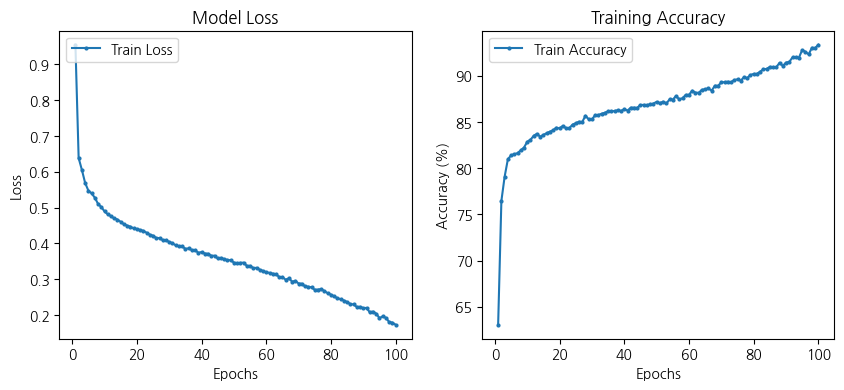


✅ 학습 그래프 저장 완료 (/content/drive/MyDrive/DMS/test_LSTM/baseline_lstm_results/train_results.png)



In [ ]:
plot_train_results(epoch_losses, epoch_scores, config["train_result_path"])

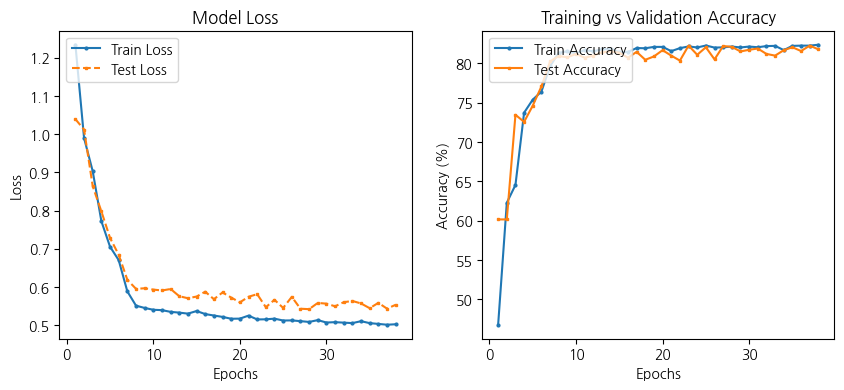


✅ 학습 및 검증 그래프 저장 완료 (/content/drive/MyDrive/DMS/LSTM_baseline/train_result/training_results.png)



In [ ]:
plot_train_test_results(
    epoch_train_losses,
    epoch_train_scores,
    epoch_valid_losses,
    epoch_valid_scores,
    save_path=config["train_result_path"],
)

### 마지막 학습률 확인

In [ ]:
def get_current_lr(optimizer):
    return [param_group["lr"] for param_group in optimizer.param_groups]

current_lr = get_current_lr(optimizer)
print(f"🚀 현재 Learning Rate: {current_lr}")

🚀 현재 Learning Rate: [1.25e-05]


In [ ]:
scheduler.get_last_lr()

[1.25e-05]

### confusion matrix 시각화

In [ ]:
# 모델 로드 함수
def load_model(model, model_save_path, device):
    """저장된 모델을 불러오는 함수"""
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_save_path}")
    return model

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Confusion Matrix를 그리는 함수
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n🔹 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# 학습 데이터에서 Confusion Matrix 계산
def evaluate_model(model, data_loader, class_names):
    """
    모델을 평가하고 Confusion Matrix를 출력하는 함수
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

            y_pred = model(x_batch)  # (batch_size, num_classes)
            y_pred_classes = torch.argmax(y_pred, dim=1)  # 가장 높은 확률을 가진 클래스를 예측값으로 선택

            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix 출력
    plot_confusion_matrix(all_labels, all_preds, class_names)

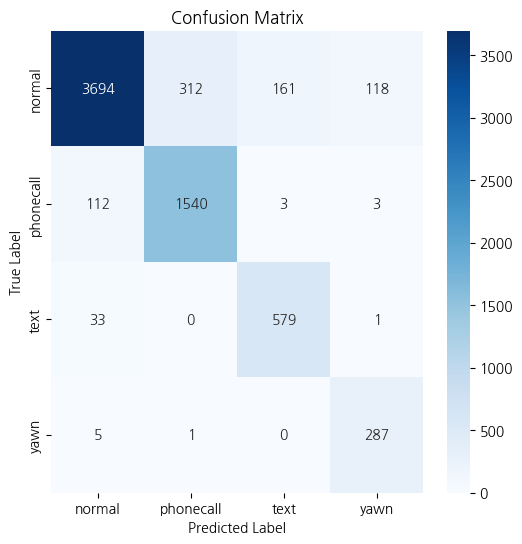


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.96      0.86      0.91      4285
   phonecall       0.83      0.93      0.88      1658
        text       0.78      0.94      0.85       613
        yawn       0.70      0.98      0.82       293

    accuracy                           0.89      6849
   macro avg       0.82      0.93      0.86      6849
weighted avg       0.90      0.89      0.89      6849



In [ ]:
# model_path = "/content/drive/MyDrive/DMS/LSTM_baseline/save_model/best_model_2025-03-16.pth"
# model_path = "/content/drive/MyDrive/DMS/LSTM_baseline/baseline_lstm_ckpt/best_model_2025-03-16.pth"
# model_path = "/content/drive/MyDrive/DMS/data/model_results/031716_2s_sliding/best_model_2025-03-17.pth"
model_path = "/content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth"

# 저장된 체크포인트 로드
checkpoint = torch.load(model_path, map_location=config['device'])
# 모델 객체 생성 후 가중치 로드
model = DecoderRNN(config)
model.load_state_dict(checkpoint["model_state_dict"])  # 올바른 state_dict 키 사용
model.to(device)  # 모델을 GPU로 이동
model.eval()

class_names = config['action_names']
evaluate_model(model, train_loader, class_names)

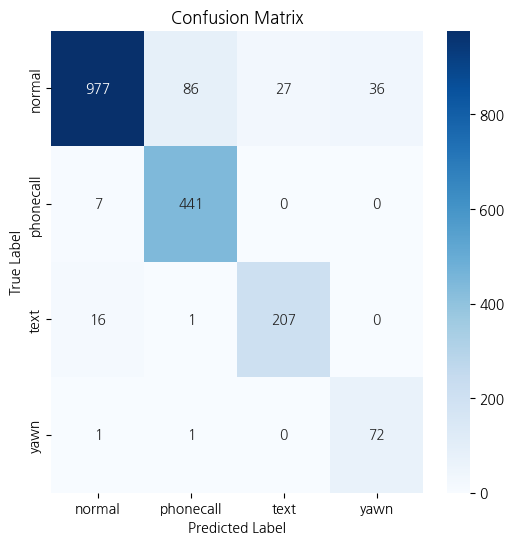


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.98      0.87      0.92      1126
   phonecall       0.83      0.98      0.90       448
        text       0.88      0.92      0.90       224
        yawn       0.67      0.97      0.79        74

    accuracy                           0.91      1872
   macro avg       0.84      0.94      0.88      1872
weighted avg       0.92      0.91      0.91      1872



In [ ]:
evaluate_model(model, valid_loader, class_names)

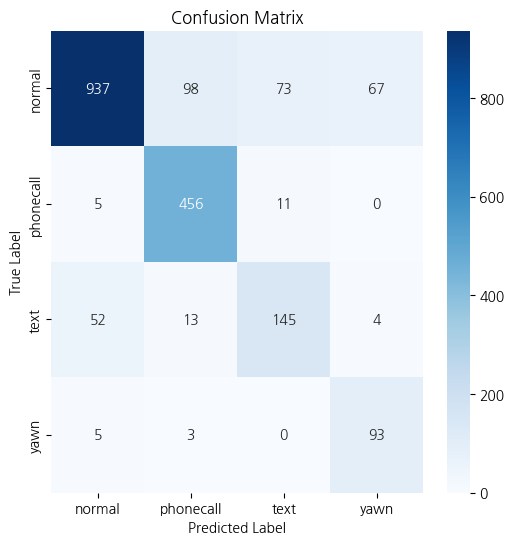


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.94      0.80      0.86      1175
   phonecall       0.80      0.97      0.88       472
        text       0.63      0.68      0.65       214
        yawn       0.57      0.92      0.70       101

    accuracy                           0.83      1962
   macro avg       0.73      0.84      0.77      1962
weighted avg       0.85      0.83      0.83      1962



In [ ]:
evaluate_model(model, test_loader, class_names)

# 2. 테스트 코드
1. **동영상에서 프레임 추출**
2. **12개씩 프레임 묶음 (시퀀스 단위)**
3. **특징 추출 (Pitch, Yaw, EAR, MAR, Phone 사용 여부)**
4. **특징값 병합**
5. **LSTM Input 형식 변환**
6. **LSTM 모델 예측 (테스트 수행)**

# 24frame 4초로 데이터 로드

In [ ]:
import os
import numpy as np

def merge_video_parts_to_24frames(data_dir, save_dir):
    """
    한 비디오의 여러 `part-*` 파일들을 순서대로 합쳐 24프레임씩 묶어 저장하는 함수.

    Args:
        data_dir (str): 기존 12프레임 묶음 데이터가 저장된 디렉토리.
        save_dir (str): 24프레임으로 변환된 데이터를 저장할 디렉토리.
    """
    os.makedirs(save_dir, exist_ok=True)  # 저장할 디렉토리 생성

    # ✅ 12프레임 묶음 파일 리스트 가져오기
    all_files = sorted(os.listdir(data_dir))  # 파일 이름 기준 정렬
    video_dict = {}

    # ✅ 비디오별로 `part-*`를 그룹화
    for file in all_files:
        if not file.endswith(".npz"):  # ✅ npz 파일이 아니면 스킵
            continue
        video_name, part = file.rsplit("_", 1)  # ✅ 비디오 이름과 `part-*` 분리
        video_dict.setdefault(video_name, []).append(file)

    # ✅ 각 비디오별로 `part-*`들을 24프레임 단위로 묶어서 저장
    for video_name, parts in video_dict.items():
        parts.sort()  # ✅ part 순서대로 정렬
        merged_features = []
        merged_labels = []
        part_count = 0

        for part_file in parts:
            part_data = np.load(os.path.join(data_dir, part_file), allow_pickle=True)

            # ✅ 기존 12프레임 데이터 추가
            merged_features.append(part_data["features"])
            merged_labels.append(part_data["labels"])

            # ✅ 24프레임이 채워졌을 경우 저장
            if len(merged_features) == 2:  # 12프레임 x 2 = 24프레임
                full_features = np.concatenate(merged_features, axis=0)
                full_labels = np.concatenate(merged_labels, axis=0)

                # ✅ 저장할 파일명 생성
                merged_file_name = f"{video_name}_merged-{part_count}.npz"
                save_path = os.path.join(save_dir, merged_file_name)

                # ✅ 데이터 저장
                np.savez_compressed(save_path, features=full_features, labels=full_labels)
                print(f"✅ Saved: {save_path}")

                # ✅ 초기화
                merged_features = []
                merged_labels = []
                part_count += 1

        # ✅ 남은 데이터(12프레임 미만)도 저장
        if merged_features:
            remaining_features = np.concatenate(merged_features, axis=0)
            remaining_labels = np.concatenate(merged_labels, axis=0)

            remaining_file_name = f"{video_name}_merged-{part_count}.npz"
            save_path = os.path.join(save_dir, remaining_file_name)
            np.savez_compressed(save_path, features=remaining_features, labels=remaining_labels)
            print(f"✅ Saved (Remaining): {save_path}")

    print("🎉 모든 비디오의 `part-*`를 24프레임 단위로 변환 완료!")

# ✅ 변환 실행 예제
data_dir = "/content/drive/MyDrive/DMS/12_frame_batches"
save_dir = "/content/drive/MyDrive/DMS/24_frame_batches"

merge_video_parts_to_24frames(data_dir, save_dir)


In [ ]:
train.head(50)

,label,video_name,frame,pitch,yaw,avg_EAR,MAR,part
0,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000000.jpg,-0.802380,-0.178544,0.188577,0.152621,1
1,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000001.jpg,-0.258022,-0.444779,0.115461,0.098821,1
2,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000002.jpg,0.173530,-0.746606,0.101308,0.080448,1
3,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000003.jpg,-0.022168,-0.725515,0.101270,0.099019,1
4,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000004.jpg,-0.187156,-0.672688,0.110530,0.118148,1
5,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000005.jpg,-0.081897,-0.417988,0.106606,0.104334,1
6,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000006.jpg,-0.057508,-0.357123,0.107029,0.078543,1
7,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000007.jpg,-0.095150,-0.293449,0.127666,0.199588,1
8,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000008.jpg,-0.029999,-0.322888,0.131944,0.162603,1
9,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000009.jpg,-0.083665,-0.351652,0.128290,0.163139,1


In [ ]:
train.video_name[23]

'gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1.avi_part1'

In [ ]:
train.video_name[24]

'gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1.avi_part2'

In [ ]:
video_names = train['video_name']
video_clip = []
parts = []
for video_name in video_names:
    splited = video_name.split('_')
    part = splited[-1][4:]
    parts.append(part)
    video_clip.append(''.join(splited[:-1]))
train['part'] = parts
train['video_clip'] = video_clip

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104652 entries, 0 to 104939
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   label       104652 non-null  object 
 1   video_name  104652 non-null  object 
 2   frame       104652 non-null  object 
 3   pitch       104652 non-null  float64
 4   yaw         104652 non-null  float64
 5   avg_EAR     104652 non-null  float64
 6   MAR         104652 non-null  float64
 7   part        104652 non-null  object 
 8   video_clip  104652 non-null  object 
dtypes: float64(4), object(5)
memory usage: 12.0+ MB


In [ ]:
train[20:30]

,label,video_name,frame,pitch,yaw,avg_EAR,MAR,part,video_clip
20,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000008.jpg,-0.474184,0.133306,0.144544,0.047267,1,gB-10(File10)s1face2019-03-11-152454101.avi
21,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000009.jpg,-0.705404,0.108137,0.163965,0.035382,1,gB-10(File10)s1face2019-03-11-152454101.avi
22,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000010.jpg,-0.690933,0.116257,0.156006,0.039635,1,gB-10(File10)s1face2019-03-11-152454101.avi
23,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000011.jpg,-0.238112,0.213462,0.136346,0.053967,1,gB-10(File10)s1face2019-03-11-152454101.avi
24,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000012.jpg,-0.237376,0.338889,0.142157,0.025646,2,gB-10(File10)s1face2019-03-11-152454101.avi
25,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000013.jpg,-0.241783,0.256069,0.137999,0.035989,2,gB-10(File10)s1face2019-03-11-152454101.avi
26,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000014.jpg,-0.305443,0.313501,0.135850,0.025056,2,gB-10(File10)s1face2019-03-11-152454101.avi
27,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000015.jpg,-0.215230,0.310252,0.136343,0.029065,2,gB-10(File10)s1face2019-03-11-152454101.avi
28,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000016.jpg,-0.168923,0.303076,0.156912,0.026932,2,gB-10(File10)s1face2019-03-11-152454101.avi
29,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_1...,frame000017.jpg,-0.160947,0.366042,0.154081,0.018471,2,gB-10(File10)s1face2019-03-11-152454101.avi


In [ ]:
timestep = 24

grouped = train.groupby("video_clip")
sequences = []

for _, group in grouped:
    group = group.sort_values(by="frame")  # 프레임 순서 정렬
    features = group[["pitch", "yaw", "avg_EAR", "MAR"]].values
    labels = group["label"].values

    num_samples = len(features) // timestep  # 가능한 샘플 개수
    features = features[:num_samples * timestep]  # 24 프레임 단위로 자르기
    labels = labels[:num_samples * timestep]  # 라벨도 동일하게 자르기

    # (샘플 개수, 24, 특성 수) 형태로 변환
    features = features.reshape(num_samples, timestep, -1)


ValueError: cannot reshape array of size 0 into shape (0,24,newaxis)

In [ ]:
sequences

[(array([[ 0.13482253, -0.0524254 ,  0.08242809,  0.15493202],
         [ 0.05477936,  0.05504221,  0.11030949,  0.17709492],
         [ 0.10956458,  0.07453336,  0.12162362,  0.09462981],
         [ 0.0704715 ,  0.07735764,  0.12705756,  0.09500459],
         [-0.07684498, -0.68677896,  0.0736597 ,  0.11221357],
         [ 0.07015593,  0.04702264,  0.10386647,  0.1325756 ],
         [ 0.09466739,  0.07578984,  0.12021892,  0.16898289],
         [ 0.07025819,  0.07453949,  0.1163146 ,  0.32163674],
         [ 0.05162298,  0.06797479,  0.11684658,  0.27434696],
         [ 0.06828292,  0.08553647,  0.125931  ,  0.4146161 ],
         [ 0.04754009,  0.08469092,  0.12707507,  0.43604702],
         [ 0.03346742,  0.07567506,  0.13568326,  0.40378463],
         [ 0.12589535,  0.03884487,  0.13286173,  0.42098365],
         [ 0.12262473,  0.00409062,  0.13692523,  0.37787256],
         [ 0.09037624,  0.06569326,  0.12425996,  0.30625247],
         [ 0.15921043,  0.0594801 ,  0.12676402,  0.428

In [ ]:
group

,label,video_name,frame,pitch,yaw,avg_EAR,MAR,part,video_clip
100752,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000000.jpg,-0.414229,0.458344,0.083193,0.281397,1,dash11-FemaleGlasses.avi-clip-0
100753,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000001.jpg,-0.589805,0.288127,0.075220,0.240167,1,dash11-FemaleGlasses.avi-clip-0
100754,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000002.jpg,-0.704458,0.007384,0.098824,0.093542,1,dash11-FemaleGlasses.avi-clip-0
100755,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000003.jpg,-0.713450,-0.037629,0.094461,0.274826,1,dash11-FemaleGlasses.avi-clip-0
100756,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000004.jpg,-0.473308,0.199544,0.097388,0.574758,1,dash11-FemaleGlasses.avi-clip-0
100757,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000005.jpg,-0.650152,0.132989,0.103213,0.531745,1,dash11-FemaleGlasses.avi-clip-0
100758,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000006.jpg,-0.684206,0.138696,0.090529,0.513216,1,dash11-FemaleGlasses.avi-clip-0
100759,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000007.jpg,-0.725110,0.087165,0.104358,0.469601,1,dash11-FemaleGlasses.avi-clip-0
100760,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000008.jpg,-0.695521,0.063659,0.102815,0.419084,1,dash11-FemaleGlasses.avi-clip-0
100761,yawn,dash11-FemaleGlasses.avi-clip-0_part1,frame000009.jpg,-0.227653,0.073625,0.102726,0.421700,1,dash11-FemaleGlasses.avi-clip-0


In [ ]:
features

array([], shape=(0, 4), dtype=float64)

In [ ]:
labels

array([['yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn',
        'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn',
        'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn'],
       ['yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn',
        'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn',
        'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn', 'yawn']],
      dtype=object)

In [ ]:
group

,label,video_name,frame,pitch,yaw,avg_EAR,MAR,part,video_clip
100536,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000000.jpg,0.134823,-0.052425,0.082428,0.154932,1,dash1-FemaleNoGlasses-clip-0
100537,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000001.jpg,0.054779,0.055042,0.110309,0.177095,1,dash1-FemaleNoGlasses-clip-0
100538,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000002.jpg,0.109565,0.074533,0.121624,0.094630,1,dash1-FemaleNoGlasses-clip-0
100539,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000003.jpg,0.070472,0.077358,0.127058,0.095005,1,dash1-FemaleNoGlasses-clip-0
100540,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000004.jpg,-0.076845,-0.686779,0.073660,0.112214,1,dash1-FemaleNoGlasses-clip-0
100541,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000005.jpg,0.070156,0.047023,0.103866,0.132576,1,dash1-FemaleNoGlasses-clip-0
100542,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000006.jpg,0.094667,0.075790,0.120219,0.168983,1,dash1-FemaleNoGlasses-clip-0
100543,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000007.jpg,0.070258,0.074539,0.116315,0.321637,1,dash1-FemaleNoGlasses-clip-0
100544,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000008.jpg,0.051623,0.067975,0.116847,0.274347,1,dash1-FemaleNoGlasses-clip-0
100545,yawn,dash1-FemaleNoGlasses-clip-0_part1,frame000009.jpg,0.068283,0.085536,0.125931,0.414616,1,dash1-FemaleNoGlasses-clip-0
